<a href="https://colab.research.google.com/github/kavinponnusamy01/Novintix-/blob/main/Air_Quality.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Delhi Air Pollution Analysis**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# Set style for better visualizations
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

# Load the dataset
df = pd.read_csv('Delhi_AQIBulletins.csv')

# Convert date column to datetime
df['date'] = pd.to_datetime(df['date'])

# Sort by date
df = df.sort_values('date').reset_index(drop=True)

print("Dataset Overview:")
print(f"Shape: {df.shape}")
print(f"Date Range: {df['date'].min()} to {df['date'].max()}")
print(f"Missing Values:\n{df.isnull().sum()}")

Dataset Overview:
Shape: (3143, 6)
Date Range: 2015-05-01 00:00:00 to 2023-12-31 00:00:00
Missing Values:
date                    0
City                    0
No. Stations           13
Air Quality             0
Index Value             0
Prominent Pollutant     0
dtype: int64


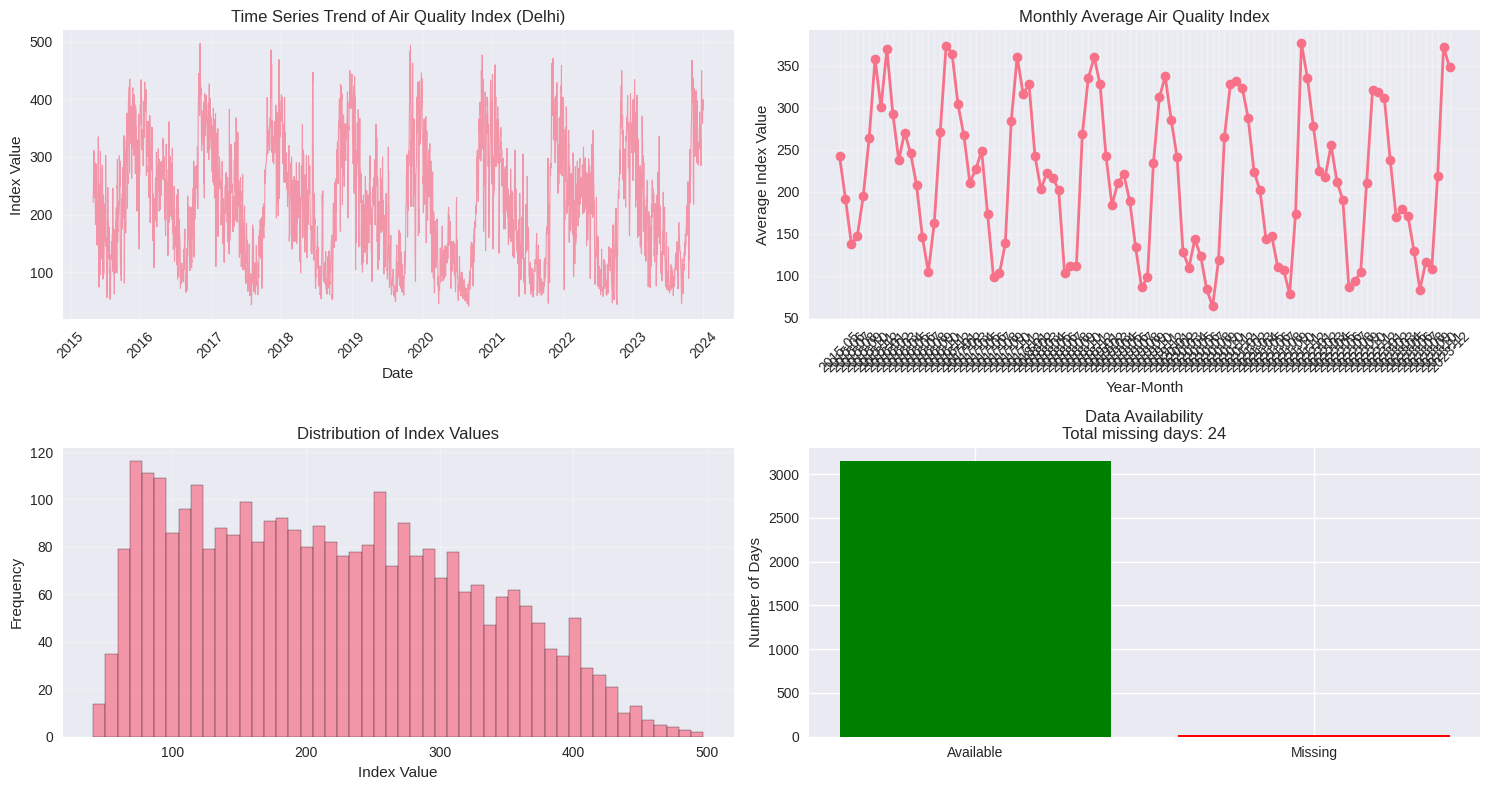


Statistical Summary:
Mean Index Value: 217.14
Median Index Value: 209.00
Standard Deviation: 104.01
Number of outliers (IQR method): 0
Missing days in date range: 24


In [2]:
# Task 1.1: Time-series trend of Index Value
plt.figure(figsize=(15, 8))

# Plot 1: Overall trend
plt.subplot(2, 2, 1)
plt.plot(df['date'], df['Index Value'], alpha=0.7, linewidth=0.8)
plt.title('Time Series Trend of Air Quality Index (Delhi)')
plt.xlabel('Date')
plt.ylabel('Index Value')
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3)

# Plot 2: Monthly averages to see trend better
plt.subplot(2, 2, 2)
df['year_month'] = df['date'].dt.to_period('M')
monthly_avg = df.groupby('year_month')['Index Value'].mean().reset_index()
monthly_avg['year_month'] = monthly_avg['year_month'].astype(str)
plt.plot(monthly_avg['year_month'], monthly_avg['Index Value'], marker='o', linewidth=2)
plt.title('Monthly Average Air Quality Index')
plt.xlabel('Year-Month')
plt.ylabel('Average Index Value')
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3)

# Plot 3: Distribution of Index Values
plt.subplot(2, 2, 3)
plt.hist(df['Index Value'], bins=50, alpha=0.7, edgecolor='black')
plt.title('Distribution of Index Values')
plt.xlabel('Index Value')
plt.ylabel('Frequency')
plt.grid(True, alpha=0.3)

# Plot 4: Missing data pattern
plt.subplot(2, 2, 4)
missing_dates = pd.date_range(start=df['date'].min(), end=df['date'].max())
actual_dates = set(df['date'])
missing_count = len([d for d in missing_dates if d not in actual_dates])
plt.bar(['Available', 'Missing'], [len(actual_dates), missing_count], color=['green', 'red'])
plt.title(f'Data Availability\nTotal missing days: {missing_count}')
plt.ylabel('Number of Days')

plt.tight_layout()
plt.show()

# Identify abnormal readings (outliers)
Q1 = df['Index Value'].quantile(0.25)
Q3 = df['Index Value'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

outliers = df[(df['Index Value'] < lower_bound) | (df['Index Value'] > upper_bound)]
print(f"\nStatistical Summary:")
print(f"Mean Index Value: {df['Index Value'].mean():.2f}")
print(f"Median Index Value: {df['Index Value'].median():.2f}")
print(f"Standard Deviation: {df['Index Value'].std():.2f}")
print(f"Number of outliers (IQR method): {len(outliers)}")
print(f"Missing days in date range: {missing_count}")

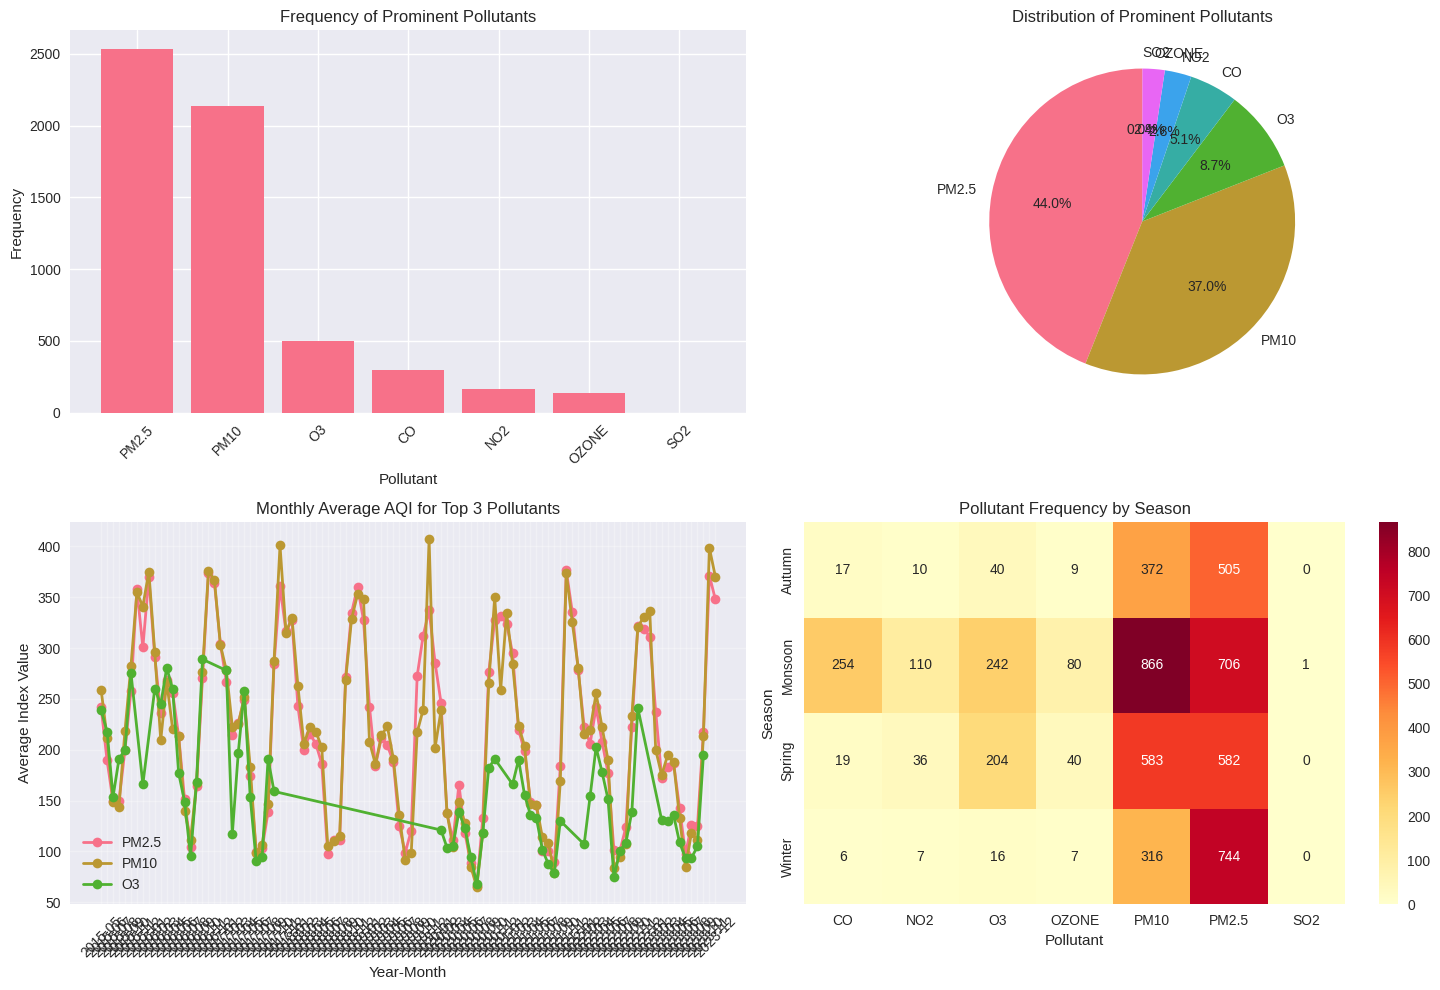


Pollutant Analysis:
Total unique pollutants: 7
Pollutant frequencies:
  PM2.5: 2537 occurrences
  PM10: 2137 occurrences
  O3: 502 occurrences
  CO: 296 occurrences
  NO2: 163 occurrences
  OZONE: 136 occurrences
  SO2: 1 occurrences


In [3]:
# Task 1.2: Distribution of Prominent Pollutant
plt.figure(figsize=(15, 10))

# Clean and process pollutant data
df['Prominent Pollutant'] = df['Prominent Pollutant'].astype(str)

# Count individual pollutants (handling multiple pollutants)
from collections import Counter
all_pollutants = []
for pollutants in df['Prominent Pollutant']:
    if pollutants != 'nan':
        # Split by comma and clean
        poll_list = [p.strip() for p in pollutants.split(',')]
        all_pollutants.extend(poll_list)

pollutant_counts = Counter(all_pollutants)

# Plot 1: Bar chart of pollutant frequencies
plt.subplot(2, 2, 1)
pollutants_df = pd.DataFrame(pollutant_counts.items(), columns=['Pollutant', 'Count']).sort_values('Count', ascending=False)
plt.bar(pollutants_df['Pollutant'], pollutants_df['Count'])
plt.title('Frequency of Prominent Pollutants')
plt.xlabel('Pollutant')
plt.ylabel('Frequency')
plt.xticks(rotation=45)

# Plot 2: Pie chart of pollutant distribution
plt.subplot(2, 2, 2)
plt.pie(pollutants_df['Count'], labels=pollutants_df['Pollutant'], autopct='%1.1f%%', startangle=90)
plt.title('Distribution of Prominent Pollutants')

# Plot 3: Pollutant trends over time (simplified - top 3 pollutants)
plt.subplot(2, 2, 3)
top_pollutants = pollutants_df.head(3)['Pollutant'].tolist()

for pollutant in top_pollutants:
    # Create a mask for days where this pollutant was prominent
    mask = df['Prominent Pollutant'].str.contains(pollutant, na=False)
    pollutant_dates = df[mask]
    monthly_pollutant = pollutant_dates.groupby('year_month')['Index Value'].mean()
    plt.plot(monthly_pollutant.index.astype(str), monthly_pollutant.values,
             marker='o', label=pollutant, linewidth=2)

plt.title('Monthly Average AQI for Top 3 Pollutants')
plt.xlabel('Year-Month')
plt.ylabel('Average Index Value')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True, alpha=0.3)

# Plot 4: Heatmap of pollutants by season
plt.subplot(2, 2, 4)
df['month'] = df['date'].dt.month
df['season'] = df['month'].apply(lambda x: 'Winter' if x in [12,1,2] else
                                'Spring' if x in [3,4,5] else
                                'Monsoon' if x in [6,7,8,9] else 'Autumn')

season_pollutant = []
for _, row in df.iterrows():
    if row['Prominent Pollutant'] != 'nan':
        pollutants = [p.strip() for p in row['Prominent Pollutant'].split(',')]
        for poll in pollutants:
            season_pollutant.append({'season': row['season'], 'pollutant': poll})

season_pollutant_df = pd.DataFrame(season_pollutant)
heatmap_data = pd.crosstab(season_pollutant_df['season'], season_pollutant_df['pollutant'])
sns.heatmap(heatmap_data, annot=True, cmap='YlOrRd', fmt='d')
plt.title('Pollutant Frequency by Season')
plt.xlabel('Pollutant')
plt.ylabel('Season')

plt.tight_layout()
plt.show()

print("\nPollutant Analysis:")
print(f"Total unique pollutants: {len(pollutant_counts)}")
print("Pollutant frequencies:")
for poll, count in pollutant_counts.most_common():
    print(f"  {poll}: {count} occurrences")

Time series features shape: (3136, 13)
Features: ['Index Value', 'lag_1', 'lag_2', 'lag_3', 'lag_4', 'lag_5', 'lag_6', 'lag_7', 'rolling_mean_7', 'rolling_std_7', 'day_of_week', 'month', 'year']
Training set: (2508, 12), Testing set: (628, 12)

Model Performance:
MAE: 24.76
MSE: 1062.38
RMSE: 32.59
R² Score: 0.9032


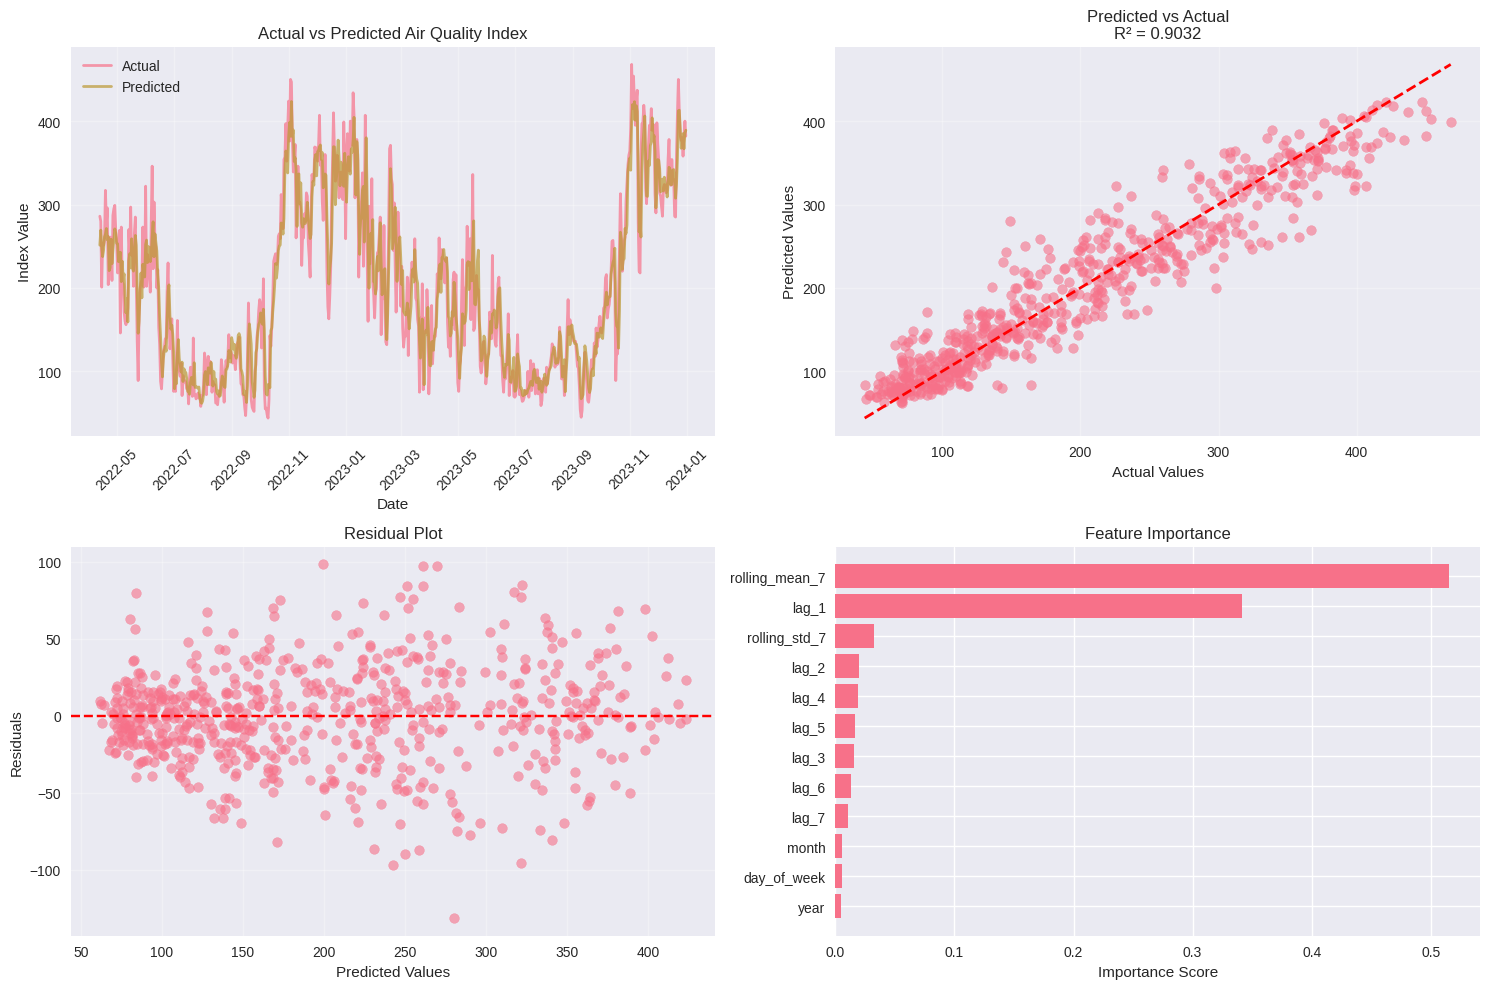

In [4]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import train_test_split

# Prepare time series data
def create_time_series_features(df, window_size=7):
    """Create windowed features for time series forecasting"""
    ts_data = df[['date', 'Index Value']].copy()
    ts_data = ts_data.set_index('date').sort_index()

    # Create lag features
    for i in range(1, window_size + 1):
        ts_data[f'lag_{i}'] = ts_data['Index Value'].shift(i)

    # Create rolling statistics
    ts_data['rolling_mean_7'] = ts_data['Index Value'].rolling(window=7).mean()
    ts_data['rolling_std_7'] = ts_data['Index Value'].rolling(window=7).std()

    # Date-based features
    ts_data['day_of_week'] = ts_data.index.dayofweek
    ts_data['month'] = ts_data.index.month
    ts_data['year'] = ts_data.index.year

    return ts_data.dropna()

# Create features
window_size = 7
ts_features = create_time_series_features(df, window_size)

print(f"Time series features shape: {ts_features.shape}")
print(f"Features: {ts_features.columns.tolist()}")

# Prepare training and testing data
X = ts_features.drop('Index Value', axis=1)
y = ts_features['Index Value']

# Split chronologically (last 20% for testing)
split_idx = int(len(X) * 0.8)
X_train, X_test = X.iloc[:split_idx], X.iloc[split_idx:]
y_train, y_test = y.iloc[:split_idx], y.iloc[split_idx:]

print(f"Training set: {X_train.shape}, Testing set: {X_test.shape}")

# Train Random Forest model
rf_model = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
rf_model.fit(X_train, y_train)

# Make predictions
y_pred = rf_model.predict(X_test)

# Calculate metrics
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print(f"\nModel Performance:")
print(f"MAE: {mae:.2f}")
print(f"MSE: {mse:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"R² Score: {r2:.4f}")

# Plot predictions vs actual
plt.figure(figsize=(15, 10))

plt.subplot(2, 2, 1)
plt.plot(y_test.index, y_test.values, label='Actual', alpha=0.7, linewidth=2)
plt.plot(y_test.index, y_pred, label='Predicted', alpha=0.7, linewidth=2)
plt.title('Actual vs Predicted Air Quality Index')
plt.xlabel('Date')
plt.ylabel('Index Value')
plt.legend()
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)

plt.subplot(2, 2, 2)
plt.scatter(y_test, y_pred, alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', linewidth=2)
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title(f'Predicted vs Actual\nR² = {r2:.4f}')
plt.grid(True, alpha=0.3)

plt.subplot(2, 2, 3)
residuals = y_test - y_pred
plt.scatter(y_pred, residuals, alpha=0.6)
plt.axhline(y=0, color='red', linestyle='--')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residual Plot')
plt.grid(True, alpha=0.3)

plt.subplot(2, 2, 4)
# Feature importance
feature_importance = pd.DataFrame({
    'feature': X.columns,
    'importance': rf_model.feature_importances_
}).sort_values('importance', ascending=True)

plt.barh(feature_importance['feature'], feature_importance['importance'])
plt.title('Feature Importance')
plt.xlabel('Importance Score')

plt.tight_layout()
plt.show()

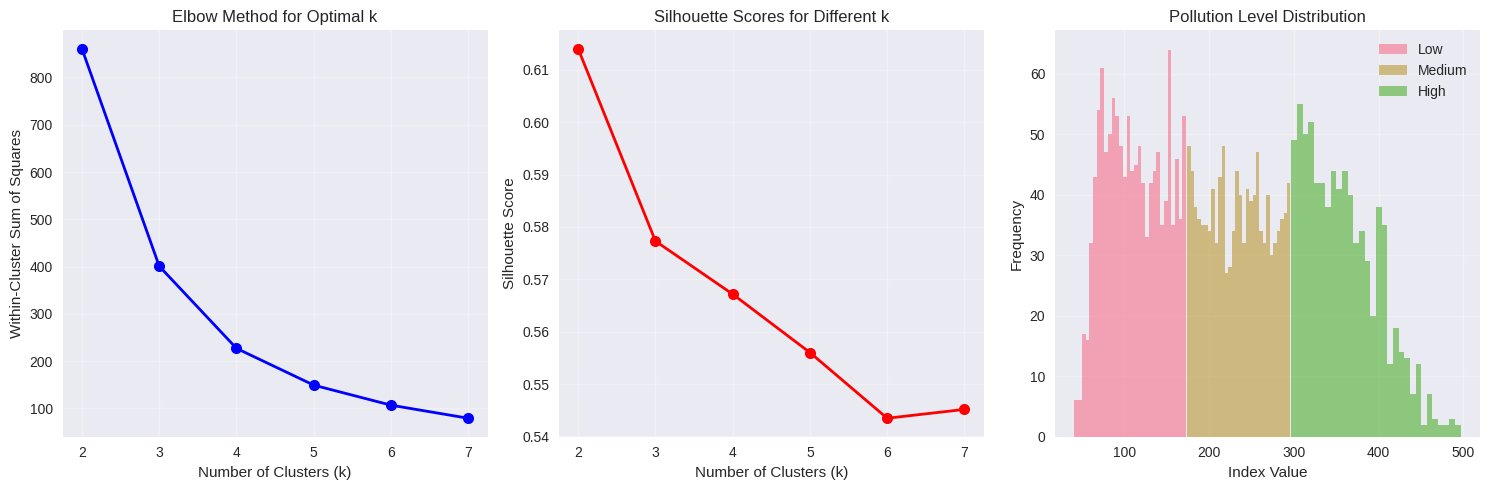


Cluster Analysis:
                   Index Value                                date           
                         count    mean    std  min  max        min        max
pollution_category                                                           
High                       782  358.92  43.12  297  497 2015-05-05 2023-12-31
Low                       1238  112.26  34.46   41  173 2015-05-21 2023-10-19
Medium                    1123  234.02  35.50  174  296 2015-05-01 2023-12-20


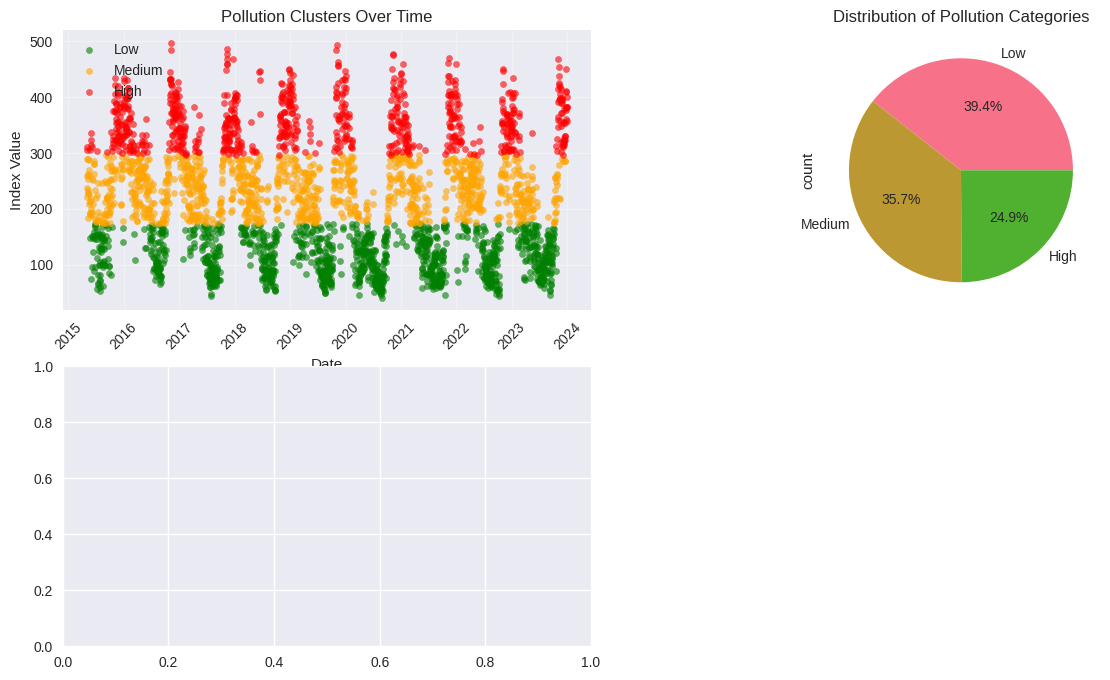

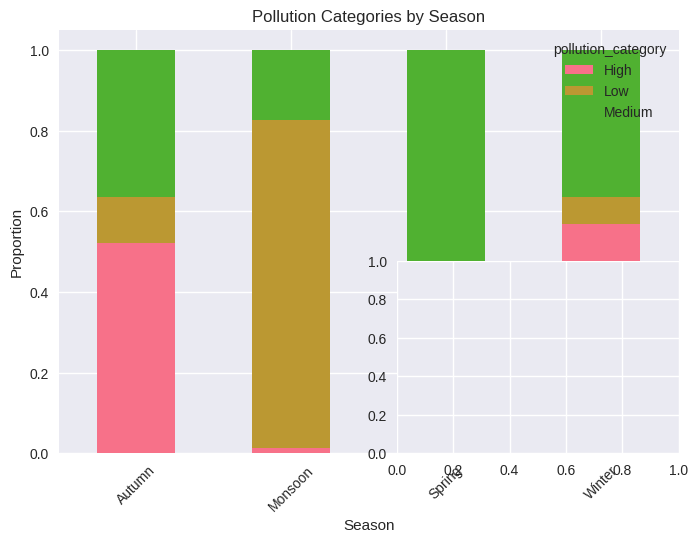

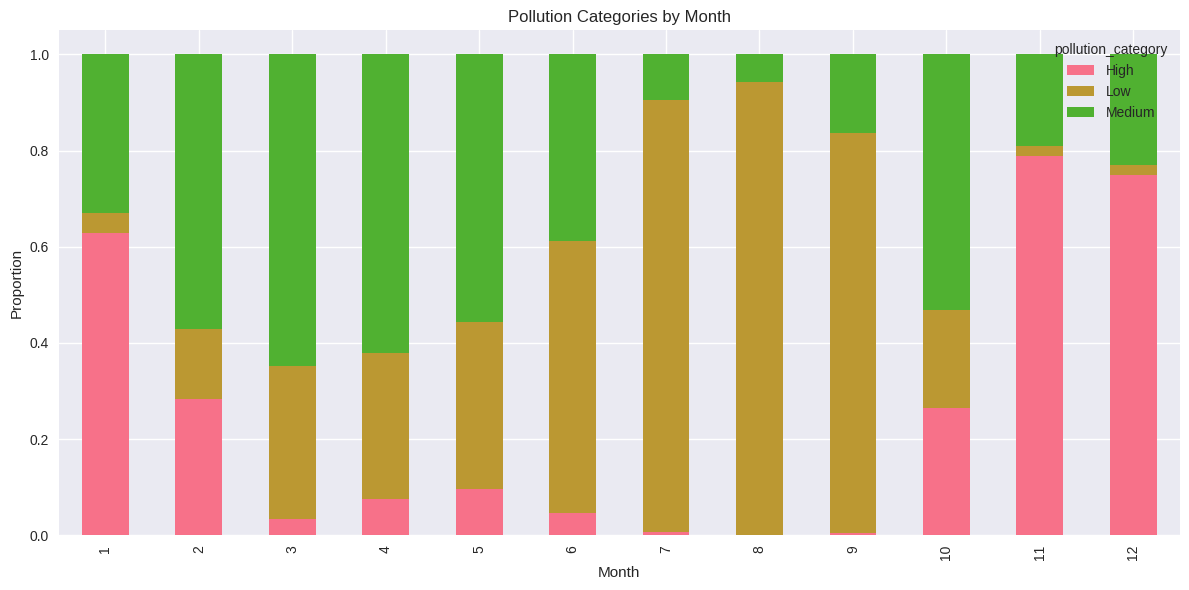


Cluster Interpretation:
Low Pollution: Average Index = 112.3, Range = 41-173, Count = 1238 days
Medium Pollution: Average Index = 234.0, Range = 174-296, Count = 1123 days
High Pollution: Average Index = 358.9, Range = 297-497, Count = 782 days


In [5]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score

# Prepare data for clustering
clustering_data = df[['Index Value']].copy()

# Scale the data
scaler = StandardScaler()
scaled_data = scaler.fit_transform(clustering_data)

# Determine optimal number of clusters using elbow method and silhouette score
wcss = []  # Within-cluster sum of squares
silhouette_scores = []
k_range = range(2, 8)

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(scaled_data)
    wcss.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(scaled_data, kmeans.labels_))

# Plot elbow method and silhouette scores
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.plot(k_range, wcss, 'bo-', linewidth=2, markersize=8)
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Within-Cluster Sum of Squares')
plt.title('Elbow Method for Optimal k')
plt.grid(True, alpha=0.3)

plt.subplot(1, 3, 2)
plt.plot(k_range, silhouette_scores, 'ro-', linewidth=2, markersize=8)
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Scores for Different k')
plt.grid(True, alpha=0.3)

# Choose k=3 for low/medium/high pollution
optimal_k = 3
kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
df['pollution_cluster'] = kmeans.fit_predict(scaled_data)

# Map clusters to pollution levels
cluster_means = df.groupby('pollution_cluster')['Index Value'].mean()
cluster_mapping = {cluster: level for level, cluster in
                  enumerate(cluster_means.sort_values().index)}
df['pollution_level'] = df['pollution_cluster'].map(cluster_mapping)
df['pollution_category'] = df['pollution_level'].map({0: 'Low', 1: 'Medium', 2: 'High'})

plt.subplot(1, 3, 3)
for level in ['Low', 'Medium', 'High']:
    level_data = df[df['pollution_category'] == level]['Index Value']
    plt.hist(level_data, alpha=0.6, label=level, bins=30)

plt.xlabel('Index Value')
plt.ylabel('Frequency')
plt.title('Pollution Level Distribution')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Cluster analysis
cluster_summary = df.groupby('pollution_category').agg({
    'Index Value': ['count', 'mean', 'std', 'min', 'max'],
    'date': ['min', 'max']
}).round(2)

print("\nCluster Analysis:")
print(cluster_summary)

# Visualize clusters over time
plt.figure(figsize=(15, 8))

plt.subplot(2, 2, 1)
colors = {'Low': 'green', 'Medium': 'orange', 'High': 'red'}
for category, color in colors.items():
    category_data = df[df['pollution_category'] == category]
    plt.scatter(category_data['date'], category_data['Index Value'],
               c=color, label=category, alpha=0.6, s=20)
plt.title('Pollution Clusters Over Time')
plt.xlabel('Date')
plt.ylabel('Index Value')
plt.legend()
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)

plt.subplot(2, 2, 2)
df['pollution_category'].value_counts().plot(kind='pie', autopct='%1.1f%%')
plt.title('Distribution of Pollution Categories')

plt.subplot(2, 2, 3)
# Seasonal distribution of clusters
season_cluster = pd.crosstab(df['season'], df['pollution_category'], normalize='index')
season_cluster.plot(kind='bar', stacked=True)
plt.title('Pollution Categories by Season')
plt.xlabel('Season')
plt.ylabel('Proportion')
plt.xticks(rotation=45)

plt.subplot(2, 2, 4)
# Monthly pattern
df['month'] = df['date'].dt.month
month_cluster = pd.crosstab(df['month'], df['pollution_category'], normalize='index')
month_cluster.plot(kind='bar', stacked=True, figsize=(12, 6))
plt.title('Pollution Categories by Month')
plt.xlabel('Month')
plt.ylabel('Proportion')

plt.tight_layout()
plt.show()

print("\nCluster Interpretation:")
for category in ['Low', 'Medium', 'High']:
    cat_data = df[df['pollution_category'] == category]
    avg_index = cat_data['Index Value'].mean()
    print(f"{category} Pollution: Average Index = {avg_index:.1f}, "
          f"Range = {cat_data['Index Value'].min():.0f}-{cat_data['Index Value'].max():.0f}, "
          f"Count = {len(cat_data)} days")

Monthly Pollution Analysis:
   month_name  Index Value_mean  Index Value_std pollution_category
0         Jan            316.12            73.99     High Pollution
1         Feb            254.65            64.21     High Pollution
2         Mar            196.15            56.62           Moderate
3         Apr            209.57            65.68     High Pollution
4         May            204.95            67.34     High Pollution
5         Jun            172.40            67.10           Moderate
6         Jul            108.63            48.49           Moderate
7         Aug            103.42            37.16           Moderate
8         Sep            123.89            51.59           Moderate
9         Oct            242.95            83.17     High Pollution
10        Nov            348.65            72.30     High Pollution
11        Dec            334.91            64.00     High Pollution


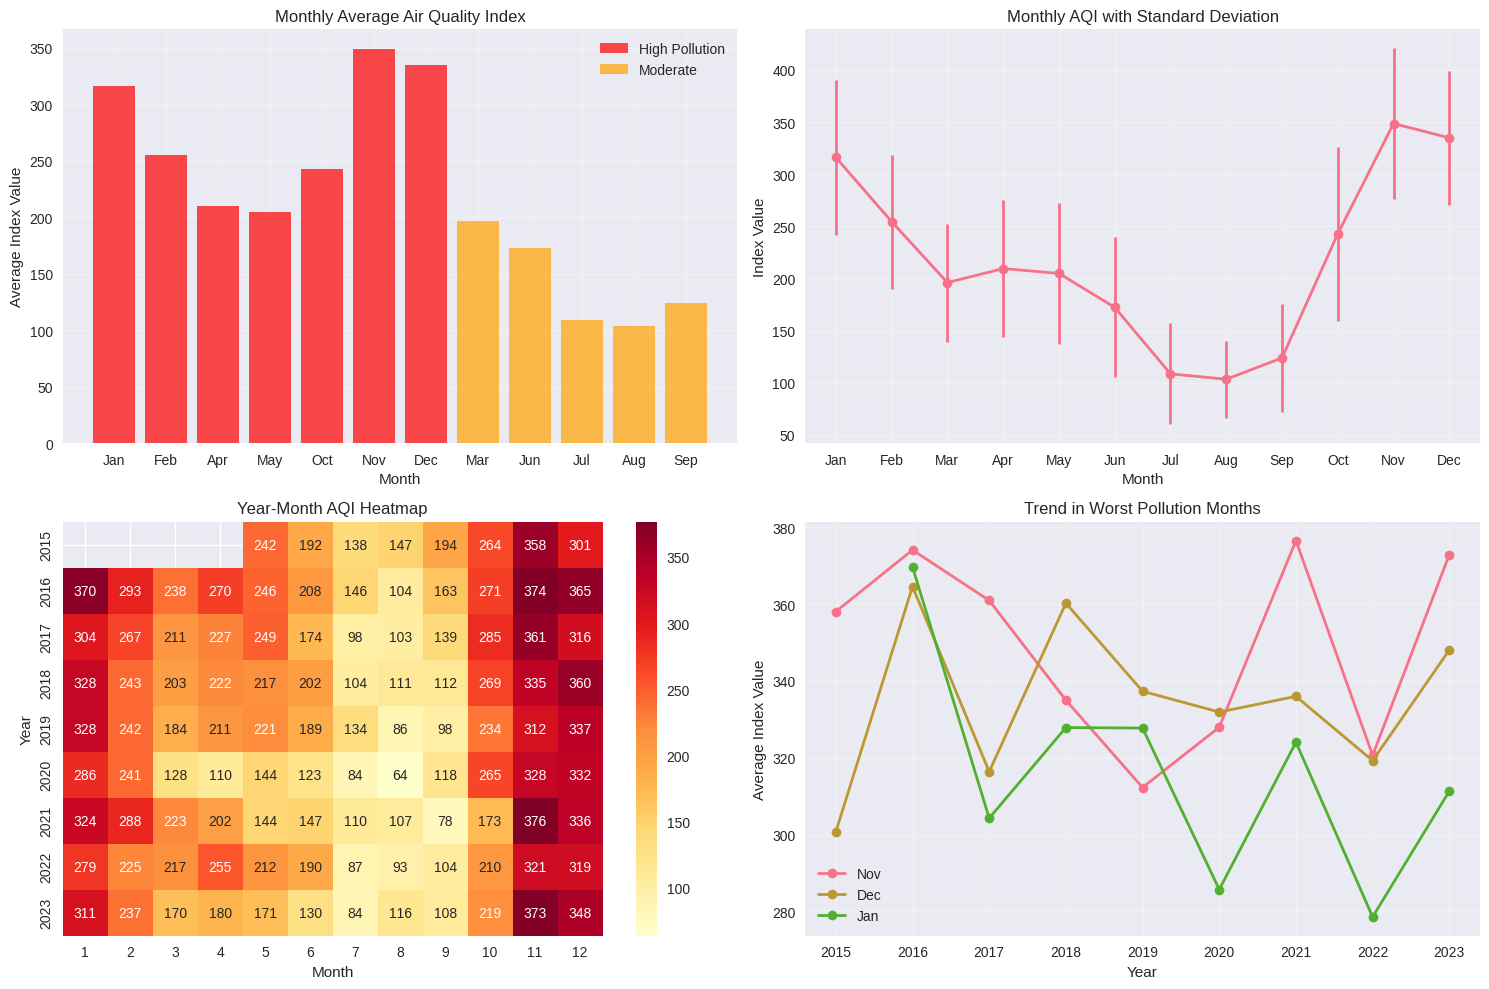


AI-GENERATED SEASONAL INSIGHTS

📊 OVERVIEW:
• Dataset covers 3143 days from 2015-05-01 to 2023-12-31
• Overall average AQI: 217.1

🔴 HIGH POLLUTION MONTHS (7 months):
   • Jan: Average AQI = 316.1
   • Feb: Average AQI = 254.7
   • Apr: Average AQI = 209.6
   • May: Average AQI = 204.9
   • Oct: Average AQI = 242.9
   • Nov: Average AQI = 348.6
   • Dec: Average AQI = 334.9

🟢 CLEANEST MONTHS (0 months):

📈 SEASONAL PATTERNS:
   • Autumn: High Pollution (Avg: 295.1 ± 94.2)
   • Monsoon: Moderate (Avg: 126.6 ± 58.5)
   • Spring: High Pollution (Avg: 203.6 ± 63.7)
   • Winter: High Pollution (Avg: 304.6 ± 75.4)

💡 KEY INSIGHTS:
1. Worst month: Nov (Avg AQI: 348.6)
2. Best month: Aug (Avg AQI: 103.4)
3. Pollution peaks typically occur in Jan, Feb, Apr, May, Oct, Nov, Dec
4. Cleanest air typically in 
5. 24.9% of days experience high pollution levels

🎯 RECOMMENDATIONS:
• Implement stricter pollution control measures during high-pollution months
• Plan outdoor activities during cleaner mo

In [6]:
# Task 4: Seasonal Pollution Pattern Analysis

# Calculate monthly statistics
monthly_stats = df.groupby('month').agg({
    'Index Value': ['mean', 'median', 'std', 'min', 'max', 'count']
}).round(2)

monthly_stats.columns = ['_'.join(col).strip() for col in monthly_stats.columns.values]
monthly_stats = monthly_stats.reset_index()

# Define pollution categories based on AQI standards
def categorize_pollution_level(avg_index):
    if avg_index <= 100:
        return 'Clean'
    elif avg_index <= 200:
        return 'Moderate'
    else:
        return 'High Pollution'

monthly_stats['pollution_category'] = monthly_stats['Index Value_mean'].apply(categorize_pollution_level)

# Month names for better visualization
month_names = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun',
              'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
monthly_stats['month_name'] = monthly_stats['month'].apply(lambda x: month_names[x-1])

print("Monthly Pollution Analysis:")
print(monthly_stats[['month_name', 'Index Value_mean', 'Index Value_std', 'pollution_category']])

# Visualization
plt.figure(figsize=(15, 10))

# Plot 1: Monthly average AQI with categories
plt.subplot(2, 2, 1)
colors = {'Clean': 'green', 'Moderate': 'orange', 'High Pollution': 'red'}
for category in monthly_stats['pollution_category'].unique():
    cat_data = monthly_stats[monthly_stats['pollution_category'] == category]
    plt.bar(cat_data['month_name'], cat_data['Index Value_mean'],
            color=colors[category], label=category, alpha=0.7)

plt.title('Monthly Average Air Quality Index')
plt.xlabel('Month')
plt.ylabel('Average Index Value')
plt.legend()
plt.grid(True, alpha=0.3)

# Plot 2: Seasonal pattern with error bars
plt.subplot(2, 2, 2)
plt.errorbar(monthly_stats['month_name'], monthly_stats['Index Value_mean'],
            yerr=monthly_stats['Index Value_std'], fmt='o-', capsize=5, linewidth=2)
plt.title('Monthly AQI with Standard Deviation')
plt.xlabel('Month')
plt.ylabel('Index Value')
plt.grid(True, alpha=0.3)

# Plot 3: Heatmap of pollution by year and month
plt.subplot(2, 2, 3)
df['year'] = df['date'].dt.year
year_month_avg = df.pivot_table(values='Index Value', index='year', columns='month', aggfunc='mean')
sns.heatmap(year_month_avg, cmap='YlOrRd', annot=True, fmt='.0f')
plt.title('Year-Month AQI Heatmap')
plt.xlabel('Month')
plt.ylabel('Year')

# Plot 4: Trend analysis for worst months
plt.subplot(2, 2, 4)
worst_months = monthly_stats.nlargest(3, 'Index Value_mean')['month'].tolist()
for month in worst_months:
    month_data = df[df['month'] == month]
    yearly_avg = month_data.groupby('year')['Index Value'].mean()
    plt.plot(yearly_avg.index, yearly_avg.values, marker='o',
             label=month_names[month-1], linewidth=2)

plt.title('Trend in Worst Pollution Months')
plt.xlabel('Year')
plt.ylabel('Average Index Value')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Generate automated insights
high_pollution_months = monthly_stats[monthly_stats['pollution_category'] == 'High Pollution']
clean_months = monthly_stats[monthly_stats['pollution_category'] == 'Clean']

print("\n" + "="*60)
print("AI-GENERATED SEASONAL INSIGHTS")
print("="*60)

print(f"\n📊 OVERVIEW:")
print(f"• Dataset covers {len(df)} days from {df['date'].min().strftime('%Y-%m-%d')} to {df['date'].max().strftime('%Y-%m-%d')}")
print(f"• Overall average AQI: {df['Index Value'].mean():.1f}")

print(f"\n🔴 HIGH POLLUTION MONTHS ({len(high_pollution_months)} months):")
for _, month in high_pollution_months.iterrows():
    print(f"   • {month['month_name']}: Average AQI = {month['Index Value_mean']:.1f}")

print(f"\n🟢 CLEANEST MONTHS ({len(clean_months)} months):")
for _, month in clean_months.iterrows():
    print(f"   • {month['month_name']}: Average AQI = {month['Index Value_mean']:.1f}")

print(f"\n📈 SEASONAL PATTERNS:")
# Analyze by Indian seasons
seasons_analysis = df.groupby('season').agg({
    'Index Value': ['mean', 'std']
}).round(1)
seasons_analysis.columns = ['_'.join(col).strip() for col in seasons_analysis.columns.values]

for season in seasons_analysis.index:
    avg = seasons_analysis.loc[season, 'Index Value_mean']
    std = seasons_analysis.loc[season, 'Index Value_std']
    category = categorize_pollution_level(avg)
    print(f"   • {season}: {category} (Avg: {avg:.1f} ± {std:.1f})")

print(f"\n💡 KEY INSIGHTS:")
worst_month = monthly_stats.loc[monthly_stats['Index Value_mean'].idxmax()]
best_month = monthly_stats.loc[monthly_stats['Index Value_mean'].idxmin()]

print(f"1. Worst month: {worst_month['month_name']} (Avg AQI: {worst_month['Index Value_mean']:.1f})")
print(f"2. Best month: {best_month['month_name']} (Avg AQI: {best_month['Index Value_mean']:.1f})")
print(f"3. Pollution peaks typically occur in {', '.join(high_pollution_months['month_name'].tolist())}")
print(f"4. Cleanest air typically in {', '.join(clean_months['month_name'].tolist())}")

# Additional insight based on clustering
high_pollution_days = len(df[df['pollution_category'] == 'High'])
total_days = len(df)
high_pollution_percentage = (high_pollution_days / total_days) * 100

print(f"5. {high_pollution_percentage:.1f}% of days experience high pollution levels")

print(f"\n🎯 RECOMMENDATIONS:")
print("• Implement stricter pollution control measures during high-pollution months")
print("• Plan outdoor activities during cleaner months")
print("• Monitor air quality closely during seasonal transitions")